# HMLR Assessment



Vincent Nwaka
- vincentwap@gmail.com
- https://vincentwap.github.io/vincent/



This notebook performs a deep NLP analysis of BBC News datasets.
- Convert zip from BBC dataset available from http://mlg.ucd.ie/datasets/bbc.html
- Sub-category classification for Business, Entertainment, and Sports using keyword heuristics
- Named Entity Recognition (NER) with spaCy to identify media personalities and their roles
- Visualisation of results using seaborn and matplotlib
- Transformers for Classification - Use DistilBERT via Hugging Face to fine-tune on BBC article subcategories.
- Event summary extraction for anything scheduled or that occurred in April
- Large Language Models (LLMs) and their fine-tuning


# Section 1: Convert ZIP to CSV File and Combine

In [4]:
!pip install matplotlib
!pip install seaborn
!pip install spacy

   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ------- -------------------------------- 1.6/8.1 MB 7.6 MB/s eta 0:00:01
   ------------------ --------------------- 3.7/8.1 MB 8.4 MB/s eta 0:00:01
   --------------------------- ------------ 5.5/8.1 MB 8.6 MB/s eta 0:00:01
   ------------------------------------ --- 7.3/8.1 MB 8.7 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 8.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   -------------------------------- ------- 1.8/2.2 MB 8.4 MB/s eta 0:00:01
   ---------------------------------------- 2.2/2.2 MB 7.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/7.0 MB ? eta -:--:--
   --------- ------------------------------ 1.6/7.0 MB 8.4 MB/s eta 0:00:01
   ------------------- -------------------- 3.4/7.0 MB 8.8 MB/s eta 0:00:01
   ------------------------------ --------- 5.2/7.0 MB 8.6 MB/s eta 0:00:01
   ------------------------------

In [6]:
import zipfile
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from collections import defaultdict

# Load spaCy English model
nlp = spacy.load("en_core_web_sm")

# Style for plots
sns.set(style="whitegrid")


In [7]:
# convert zip file to csv file

def zip_to_csv(zip_path, output_csv):
    texts, categories, filenames = [], [], []

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        for file_name in zip_ref.namelist():
            # Process only text files
            if file_name.endswith('.txt') and not file_name.endswith('NA.TXT'):
                # Extract the category from the file path (assuming structure: folder/category/filename.txt)
                parts = file_name.split('/')
                if len(parts) >= 3:
                    category = parts[-2]
                    filename = parts[-1]

                    with zip_ref.open(file_name) as file:
                        content = file.read().decode('utf-8', errors='ignore')
                        texts.append(content)
                        categories.append(category)
                        filenames.append(filename)

    # Create a DataFrame
    df = pd.DataFrame({
        'filename': filenames,
        'category': categories,
        'text': texts
    })

    # Save DataFrame to CSV
    df.to_csv(output_csv, index=False)
    print(f"CSV file created successfully: {output_csv}")

In [8]:
# zip files download from http://mlg.ucd.ie/datasets/bbc.html
bbc_zip_path = 'bbc-fulltext.zip'
bbc_sport_zip_path = 'bbcsport-fulltext.zip'

# Convert BBC News dataset to CSV
zip_to_csv(bbc_zip_path, 'bbc_news_dataset.csv')

# Convert BBC Sport dataset to CSV
zip_to_csv(bbc_sport_zip_path, 'bbc_sport_dataset.csv')

CSV file created successfully: bbc_news_dataset.csv
CSV file created successfully: bbc_sport_dataset.csv


In [9]:
# Load the two CSVs file and combied
news_df = pd.read_csv("bbc_news_dataset.csv")
sport_df = pd.read_csv("bbc_sport_dataset.csv")

# Merge into one dataset
combined_df = pd.concat([news_df, sport_df], ignore_index=True)

# Extract headlines (first line of 'text')
combined_df['headline'] = combined_df['text'].apply(lambda x: x.split('\n')[0] if isinstance(x, str) else '')


In [5]:
combined_df

,filename,category,text,headline
0,289.txt,entertainment,Musicians to tackle US red tape\n\nMusicians' ...,Musicians to tackle US red tape
1,262.txt,entertainment,"U2's desire to be number one\n\nU2, who have w...",U2's desire to be number one
2,276.txt,entertainment,Rocker Doherty in on-stage fight\n\nRock singe...,Rocker Doherty in on-stage fight
3,060.txt,entertainment,Snicket tops US box office chart\n\nThe film a...,Snicket tops US box office chart
4,074.txt,entertainment,Ocean's Twelve raids box office\n\nOcean's Twe...,Ocean's Twelve raids box office
...,...,...,...,...
2957,051.txt,tennis,Capriati out of Australian Open\n\nJennifer Ca...,Capriati out of Australian Open
2958,045.txt,tennis,Henin-Hardenne beaten on comeback\n\nJustine H...,Henin-Hardenne beaten on comeback
2959,079.txt,tennis,Moya sidesteps Davis Cup in 2005\n\nCarlos Moy...,Moya sidesteps Davis Cup in 2005
2960,092.txt,tennis,Australia miss Molik for Fed Cup\n\nAustralia ...,Australia miss Molik for Fed Cup


In [6]:
combined_df['category'].value_counts()

category
sport            511
business         510
politics         417
tech             401
entertainment    386
football         265
rugby            147
cricket          124
athletics        101
tennis           100
Name: count, dtype: int64

In [10]:
# Define subcategory keyword rules
subcat_rules = {
    'business': {
        'Stock Market': ['stock', 'stocks', 'shares', 'market', 'index', 'FTSE', 'Dow', 'Nasdaq'],
        'Mergers & Acquisitions': ['acquires', 'acquisition', 'merger', 'buys', 'takeover'],
        'Corporate News': ['company', 'CEO', 'profit', 'loss', 'launches', 'deal'],
        'Economy/Policy': ['economy', 'inflation', 'policy', 'government', 'trade']
    },
    'entertainment': {
        'Film': ['film', 'movie', 'cinema', 'box office', 'Oscar', 'actor', 'actress'],
        'Music': ['music', 'album', 'song', 'singer', 'band', 'gig'],
        'Literature': ['book', 'novel', 'author', 'literary'],
        'Theatre': ['theatre', 'play', 'stage'],
        'Television': ['TV', 'television', 'series', 'episode'],
        'Celebrity': ['celebrity', 'star', 'gossip']
    },
    'sport': {
        'Football': ['football', 'goal', 'premier league'],
        'Cricket': ['cricket', 'wicket', 'bowler'],
        'Tennis': ['tennis', 'grand slam'],
        'Rugby': ['rugby', 'scrum'],
        'Athletics': ['athletics', 'track'],
        'Olympics': ['olympics', 'olympic']
    }
}

In [13]:
def assign_subcategory(row):
    cat = row['category'].lower()
    headline = row['headline'].lower()
    if cat in subcat_rules:
        for subcat, keywords in subcat_rules[cat].items():
            if any(kw in headline for kw in keywords):
                return subcat
    return 'Other'

combined_df['subcategory'] = combined_df.apply(assign_subcategory, axis=1)

def extract_entities_with_roles(text):
    doc = nlp(text)
    roles = []
    for ent in doc.ents:
        if ent.label_ == "PERSON":
            context_window = doc[max(ent.start - 5, 0):min(ent.end + 5, len(doc))]
            ctx = context_window.text.lower()
            if 'prime minister' in ctx or 'president' in ctx or 'minister' in ctx:
                roles.append((ent.text, "Politician"))
            elif 'singer' in ctx or 'band' in ctx or 'musician' in ctx:
                roles.append((ent.text, "Musician"))
            elif 'actor' in ctx or 'actress' in ctx or 'film' in ctx:
                roles.append((ent.text, "TV/Film Personality"))
            elif 'coach' in ctx or 'striker' in ctx or 'athlete' in ctx:
                roles.append((ent.text, "Sports Personality"))
    return roles


    ent_politics_df = combined_df[combined_df['category'].isin(['entertainment', 'politics'])]
    ent_politics_df['entities_with_roles'] = ent_politics_df['text'].apply(lambda x: extract_entities_with_roles(str(x)))
    named_entities_df = ent_politics_df[ent_politics_df['entities_with_roles'].str.len() > 0]

C:\Users\Vincent\AppData\Local\Temp\ipykernel_17704\110658798.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ent_politics_df['entities_with_roles'] = ent_politics_df['text'].apply(lambda x: extract_entities_with_roles(str(x)))


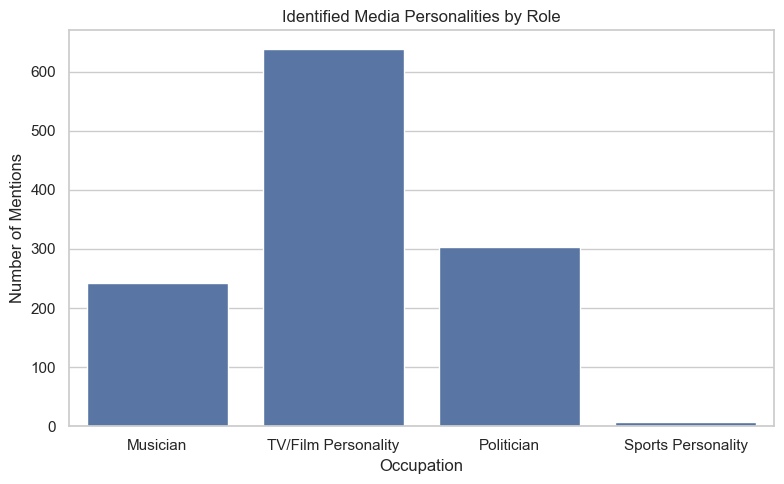

In [14]:
role_counts = defaultdict(int)
for row in named_entities_df['entities_with_roles']:
    for _, role in row:
        role_counts[role] += 1

plt.figure(figsize=(8, 5))
sns.barplot(x=list(role_counts.keys()), y=list(role_counts.values()))
plt.title("Identified Media Personalities by Role")
plt.ylabel("Number of Mentions")
plt.xlabel("Occupation")
plt.tight_layout()
plt.show()


# Section 2: DistilBERT NLP Analysis on BBC News Datasets

I use `DistilBERT` from Hugging Face Transformers to classify BBC News headlines into subcategories (e.g., Sport, Entertainment, Business).

In [9]:
# Install necessary libraries
!pip install transformers datasets accelerate -q

In [9]:
from transformers import pipeline

## Zero-shot Classification using DistilBART MNLI

In [10]:

# Load zero-shot classification pipeline
classifier = pipeline("zero-shot-classification", model="valhalla/distilbart-mnli-12-1")

# Candidate labels for demo
candidate_labels = ["Stock Market", "Corporate News", "Music", "Film", "Football", "Politics", "Technology"]

# Test classification on 5 random samples
sample_articles = combined_df.sample(5, random_state=42)['text'].tolist()

# Classify and print results
for i, article in enumerate(sample_articles):
    result = classifier(article, candidate_labels)
    print(f"Article {i+1} Top Label: {result['labels'][0]} with score {result['scores'][0]:.4f}")
    print("—" * 50)


Article 1 Top Label: Politics with score 0.2096
——————————————————————————————————————————————————
Article 2 Top Label: Politics with score 0.1591
——————————————————————————————————————————————————
Article 3 Top Label: Technology with score 0.1787
——————————————————————————————————————————————————
Article 4 Top Label: Corporate News with score 0.1651
——————————————————————————————————————————————————
Article 5 Top Label: Technology with score 0.2055
——————————————————————————————————————————————————


## Abstractive Summarisation using DistilBART

In [12]:
# Load summarisation pipeline
summariser = pipeline("summarization", model="sshleifer/distilbart-cnn-12-6")

# Sample long article
long_article = combined_df[combined_df['text'].str.len() > 500]['text'].iloc[0]

# Generate summary
summary = summariser(long_article, max_length=100, min_length=30, do_sample=False)
print("Generated Summary:\n", summary[0]['summary_text'])

Generated Summary:
  Musicians' groups call for an end to the "raw deal" faced by British performers . Musicians face tougher regulations than athletes and journalists . US acts not faced with comparable expense and bureaucracy when visiting UK for promotional purposes . Department for Media, Culture and Sport working with US embassy and record industry .


## Any Event took place in April 

In [19]:
# summary of any events that took place or were scheduled to occur in April.
april_summaries = []
for _, row in combined_df.iterrows():
    if isinstance(row['text'], str) and 'april' in row['text'].lower():
        matches = re.findall(r'([^.]*\bApril\b[^.]*\.)', row['text'], flags=re.IGNORECASE)
        for match in matches:
            if any(kw in match.lower() for kw in ['due', 'scheduled', 'took place', 'expected']):
                april_summaries.append(match.strip())

# Deduplicate
april_summaries = list(set(april_summaries))

# Display summaries
for i, summary in enumerate(april_summaries[:10], 1):
    print(f"{i}. {summary}")


1. The chair, which looks like a car seat on a skeletal frame, should go on sale in April and is expected to cost $399 (£211).
2. Filming is due to start in early April.
3. " The firm reported worldwide futures orders for athletic footwear and gear, scheduled for delivery from December 2004 to April 2005, of $4.
4. They are next due in court on 18 April.
5. Sri Lanka reschedule NZ Test tour

Sri Lanka have rescheduled their Test series in New Zealand for April after cutting short the original tour because of the Asian tsunami disaster.
6. During the interview Mr Kennedy revealed that he planned to structure the party's general election campaign around the birth of his first child, which is expected in April.
7. Tickets for the June event are expected to go on sale in April.
8. The deal, which requires regulatory approval, is expected to be completed by April 2005 and to be earnings accretive in 2006, Standard Chartered said.
9. " Shooting on the sequel is expected to begin in April, wi

In this section, I use the `T5` model to generate news headlines from the article content. `T5` is a powerful encoder-decoder model that can be used for many NLP tasks, including text summarisation.

# Section 3: Large Language Models (LLMs) and their fine-tuning

In [18]:
# Clean and prepare for fine-tuning
combined_df = combined_df[combined_df['subcategory'] != 'not_applicable']
combined_df = combined_df[~combined_df['subcategory'].isin(['classification_error'])]  # remove noisy classes
combined_df = combined_df[['text', 'subcategory']].dropna()
combined_df = combined_df[combined_df['text'].str.len() > 20]

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [22]:
# Encode labels
label_encoder = LabelEncoder()
combined_df['label'] = label_encoder.fit_transform(combined_df['subcategory'])
label_names = list(label_encoder.classes_)

In [28]:
label_counts = combined_df['label'].value_counts()
print(label_counts)

label
10    2638
4       83
8       51
2       51
12      37
3       32
1       15
7       14
6       12
15       8
14       7
0        5
11       5
13       2
9        1
5        1
Name: count, dtype: int64


In [ ]:
# There is no time to continue